In [1]:
import kwant
import numpy as np 
import matplotlib.pyplot as plt

c:\Users\manue\anaconda3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
# Fundamental constants

pi = np.pi
h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)
vf = 1e6            # Fermi velocity (m/s)
hbar = h/(2*pi)     # Reduced planck constant

epsilon_0 = 8.85e-12  # Vacuum permittivity (F/m)
epsilon_hBN = 3
epsilon_Ox = 3.8

In [3]:
# Definition of the potential
db = 20e-9 # bottom hBN layer thickness (m)
dOx = 285e-9 # substrate thickness (m)

Cbg = epsilon_0 / (db/epsilon_hBN + dOx/epsilon_Ox)

# We do not have a precise function for the capacitance linked with the CNT, so we use the approximation they provide
r_cnt = 1e-9 # CNT radius (m)
dt = 4e-9 # top hBN thickness (m)
ht = dt + r_cnt
at = np.sqrt(ht**2 - r_cnt**2)
kappa = (ht+at)**2/r_cnt**2

# Here, epsilon_r is set to have a curve resembling the simulation in the article (Ccnt/e evaluated at 0 is around 2.5e12 cm^-2 V^-1)
def computeCcnt(y, epsilon_r=2.5):
    return epsilon_0*epsilon_r*4*at/((y**2+at**2)*np.log(kappa)) # Try log10 if it does not work

In [123]:
V_cnt = 10.0  # CNT gate voltage (V)
V_bg = -13.6  # Backgate voltage (V)

In [124]:
# System maker
s = 20
a = 1/(4*np.sqrt(3)) * s
t = 3 / s

W = 360
L = 360
W_lead = 34
L_lead = L

W_well = 10
pot = 5

def potential(site):
    x, y = site.pos
    if -W_lead / 2 < y < W_lead / 2:
        return V_cnt + V_bg
    else:
        return V_bg

def cnt_region(site):
    x, y = site.pos
    return -W_lead//2 < y < W_lead//2

def cnt_potential(site, V_cnt, sigma=10):
    x, y = site.pos
    if -W_lead//2 < y < W_lead//2:
        #r = np.sqrt(x**2 + y**2)  # radial distance from CNT center
        #return V_cnt * np.exp(-r**2 / (2 * sigma**2))
        return V_cnt
    return 0

def onsite_potential(site, V_cnt, V_bg):
    return cnt_potential(site, V_cnt) + V_bg  # Combine potentials

def rect(pos):
    x, y = pos
    if -L/2 < x < L/2 and -W/2 < y < W/2:
        return True
    else:
        return False 

def lead_horizontal(pos, L=L_lead):
    x, y = pos
    return -L/2 < x < L/2

def lead_vertical(pos, W=W_lead):
    x, y = pos
    return -W/2 < y < W/2

def system_maker(V_cnt):
    lattice = kwant.lattice.general([(np.sqrt(3)*a, 0), (0, 3*a)], [(a*np.sqrt(3)/2, 0), (0, a/2), (0, 3*a/2)\
                                                                     , (a*np.sqrt(3)/2, 2*a)], norbs = 1)
    A, B, C, D = lattice.sublattices
    sys = kwant.Builder()
    hoppings = (((0, 0), B, A), ((0, 0), C, B), ((0, 0), D, C), ((-1, 0), A, B), ((-1, 0), D, C),((0, 1), A, D))
    sys[lattice.shape(rect, (0,0))] = potential
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -t
    sys.eradicate_dangling()
    
    # Create leads
    sym0 = kwant.TranslationalSymmetry(lattice.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[lattice.shape(lead_vertical, (0, 0))] = 0
    lead0[lattice.neighbors()]= -t
    lead0.eradicate_dangling()
    sys.attach_lead(lead0)
    
    sym1 = kwant.TranslationalSymmetry(lattice.vec((1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[lattice.shape(lead_vertical, (0, 0))] = 0
    lead1[lattice.neighbors()] = -t
    lead1.eradicate_dangling()
    sys.attach_lead(lead1)

    sym2 = kwant.TranslationalSymmetry(lattice.vec((0, 1)))
    lead2 = kwant.Builder(sym2)
    lead2[lattice.shape(lead_horizontal, (0, 0))] = 0
    lead2[lattice.neighbors()] = -t
    lead2.eradicate_dangling()
    sys.attach_lead(lead2)

    sym3 = kwant.TranslationalSymmetry(lattice.vec((0, -1)))
    lead3 = kwant.Builder(sym3)
    lead3[lattice.shape(lead_horizontal, (0, 0))] = 0
    lead3[lattice.neighbors()] = -t
    lead3.eradicate_dangling()
    sys.attach_lead(lead3)
    
    return sys


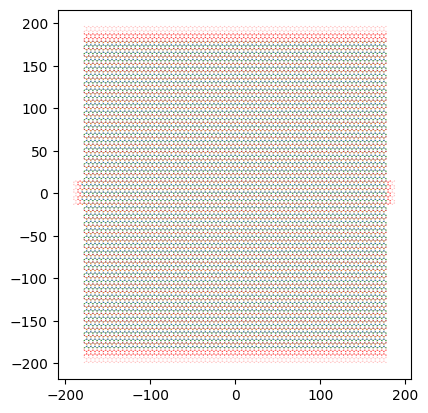

In [125]:
syst = system_maker(3)
kwant.plot(syst)
fsyst = syst.finalized()

In [107]:
kwant.plotter.map(syst, lambda site: potential)

def get_potential(site):
    """Function to extract the on-site potential from the Hamiltonian."""
    hamiltonian = fsyst.hamiltonian([site]).toarray()
    return hamiltonian[0, 0]

# Generate the site_colors dictionary
#site_colors = {site: get_potential(site) for site in fsyst.sites()}

#kwant.plotter.map(fsyst, site_colors=site_colors, cmap='inferno')

TypeError: float() argument must be a string or a number, not 'function'

c:\Users\manue\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:4405: ComplexWarning:

Casting complex values to real discards the imaginary part



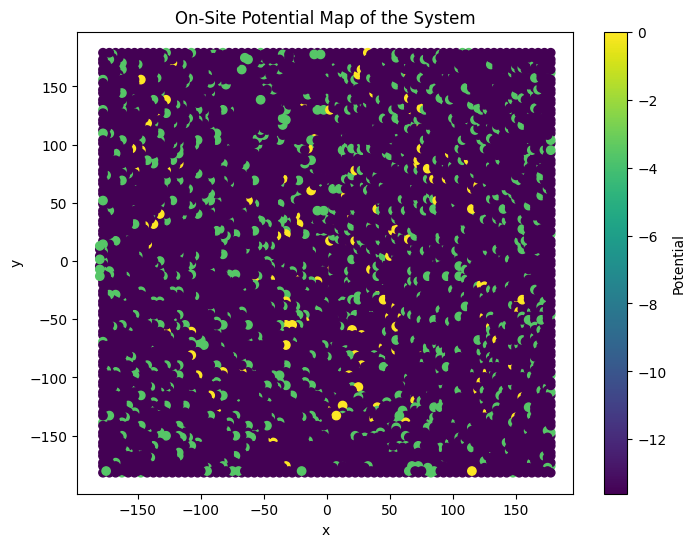

In [126]:
# Extract the Hamiltonian matrix (this gives us the on-site potential and hopping terms)
H = fsyst.hamiltonian_submatrix()

# Get the positions of the sites (the system may be large, so we'll just focus on the on-site potential)
positions = np.array([site.pos for site in syst.sites()])  # x, y positions

# Get the corresponding on-site potential values from the diagonal of the Hamiltonian
onsite_potentials = np.diag(H)

# Extract the x and y coordinates separately
x_coords, y_coords = positions[:, 0], positions[:, 1]

# Create a scatter plot where color represents the potential at each site
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=onsite_potentials, cmap='viridis', marker='o')
plt.colorbar(label="Potential")
plt.xlabel("x")
plt.ylabel("y")
plt.title("On-Site Potential Map of the System")
plt.show()

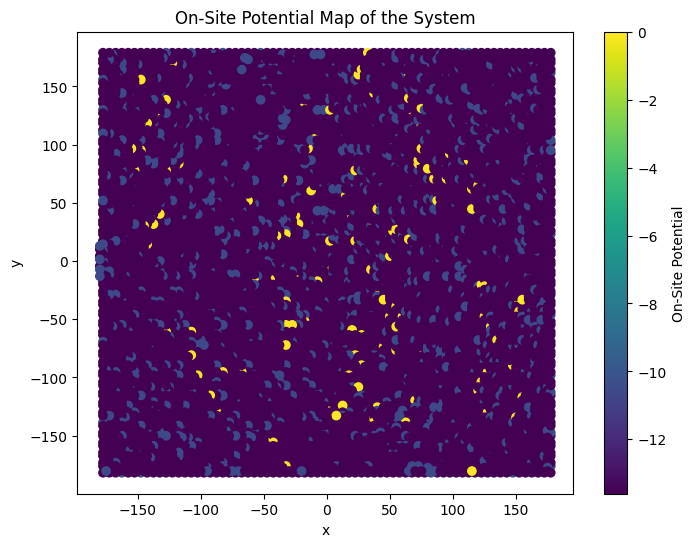

In [122]:
import kwant
import numpy as np
import matplotlib.pyplot as plt

# Assuming `sys` is your Kwant system (already created with leads and potentials)

# Extract the Hamiltonian matrix
H = fsyst.hamiltonian_submatrix()

# Get the positions of the sites in the system
positions = np.array([site.pos for site in syst.sites()])  # x, y positions

# Extract the on-site potential from the diagonal elements of the Hamiltonian matrix
# The diagonal elements of H correspond to the on-site energies
onsite_potentials = np.diag(H)

# Extract x and y coordinates from the positions
x_coords, y_coords = positions[:, 0], positions[:, 1]

# Create a scatter plot where color represents the potential at each site
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=onsite_potentials, cmap='viridis')
plt.colorbar(label="On-Site Potential")
plt.xlabel("x")
plt.ylabel("y")
plt.title("On-Site Potential Map of the System")
plt.show()


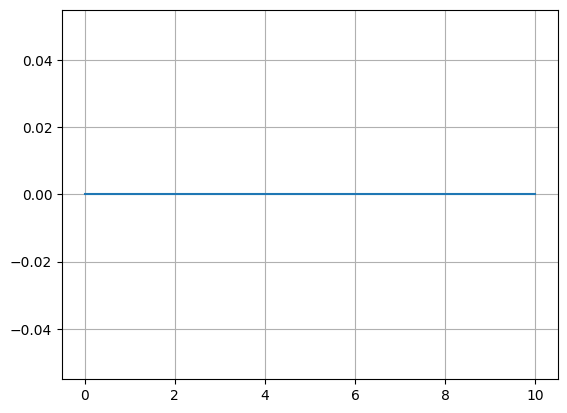

In [127]:
# Function to compute conductance
def compute_conductance(system, energy):
    smatrix = kwant.smatrix(system, energy)
    return smatrix.transmission(1, 0)

# Main simulation
V_cnt_range = np.linspace(0, 10, 10)
conductances = []
#energies = np.linspace(-0.1, 0.1, 10)
energies = 0.8
for V_cnt in V_cnt_range:
    sys = system_maker(V_cnt)
    fsys = sys.finalized()
    conductance = compute_conductance(fsys, energies)
    conductances.append(conductance)

plt.plot(V_cnt_range, conductances)
plt.grid()